# `System` <a class="anchor" id="top"></a>

* **Prepared by:**
    
    - [Yalin Li](https://qsdsan.readthedocs.io/en/latest/authors/Yalin_Li.html)

* **Covered topics:**

    - [1. Creating a simple System](#s1)
    - [2. Retrieving useful information](#s2)

- **Video demo:**

    - [Tori Morgan](https://qsdsan.readthedocs.io/en/latest/authors/Tori_Morgan.html)

To run tutorials in your browser, go to this [Binder page](https://mybinder.org/v2/gh/QSD-Group/QSDsan/main?filepath=%2Fdocs%2Fsource%2Ftutorials).

You can also watch a video demo on [YouTube](https://youtu.be/iIx28JkNjQ8) (subscriptions & likes appreciated!).

In [1]:
import qsdsan as qs
print(f'This tutorial was made with qsdsan v{qs.__version__}.')

This tutorial was made with qsdsan v1.2.0.


**Note**: although for most of the tutorials the version of `qsdsan` doesn't matter, for this tutorial you do want to use v0.3.7 or higher, which addressed some of the bugs in previous versions of `qsdsan` and `biosteam`.

## 1. Creating a simple System <a class="anchor" id="s1"></a>

`System` objects are used to organize one or more unit operations in a certain order and facilitate mass and energy convergence, techno-economic analysis (TEA), and life cycle assessment (LCA).

In [2]:
# Assume we want to look at the system in used in benchmark simulation model No.1,
# which looks like this
from IPython.display import Image
Image(url= "https://www.researchgate.net/profile/Ramon-Vilanova/publication/301305911/figure/fig1/AS:352977123594240@1461167712833/Benchmark-Simulation-Model-No-1-BSM1-plant-layout.png")

At this stage we won't include any of the process models (will be covered later in other tutorials), we will just use some surogate units to represent it

So we'll want to firstly have two anoxic reactors (mix tanks without O2), followed by three aerated reactors (mix tanks with O2), and a clarifier (splitter)

Note that we will have will also need two recycles, one from the last aerated reactor to the first anoxic reactor, and another one from the clarifer to the anoxic reactor

In [3]:
# As always, firstly we need to set the components we want to work with,
# here we will just load the default components
cmps = qs.Components.load_default()

In [4]:
# Take a look at what we have
cmps

CompiledComponents([S_H2, S_CH4, S_CH3OH, S_Ac, S_Prop, S_F, S_U_Inf, S_U_E, C_B_Subst, C_B_BAP, C_B_UAP, C_U_Inf, X_B_Subst, X_OHO_PHA, X_GAO_PHA, X_PAO_PHA, X_GAO_Gly, X_PAO_Gly, X_OHO, X_AOO, X_NOO, X_AMO, X_PAO, X_MEOLO, X_FO, X_ACO, X_HMO, X_PRO, X_U_Inf, X_U_OHO_E, X_U_PAO_E, X_Ig_ISS, X_MgCO3, X_CaCO3, X_MAP, X_HAP, X_HDP, X_FePO4, X_AlPO4, X_AlOH, X_FeOH, X_PAO_PP_Lo, X_PAO_PP_Hi, S_NH4, S_NO2, S_NO3, S_PO4, S_K, S_Ca, S_Mg, S_CO3, S_N2, S_O2, S_CAT, S_AN, H2O])


In [5]:
# Just a refresher on how to set synonym
cmps.set_alias('H2O', 'Water')
cmps.H2O == cmps.Water

True

In [6]:
# Set the components
qs.set_thermo(cmps)

In [7]:
# Make an influent waste stream
ww = qs.WasteStream.codbased_inf_model('ww', flow_tot=1000, units=('L/hr', 'mg/L'))
ww.show()

WasteStream: ww
 phase: 'l', T: 298.15 K, P: 101325 Pa
 flow (g/hr): S_F        75
              S_U_Inf    32.5
              C_B_Subst  40
              X_B_Subst  227
              X_U_Inf    55.8
              X_Ig_ISS   52.3
              S_NH4      25
              S_PO4      8
              S_K        28
              S_Ca       140
              S_Mg       50
              S_CO3      120
              S_N2       18
              S_CAT      3
              S_AN       12
              ...
 WasteStream-specific properties:
  pH         : 7.0
  Alkalinity : 10.0 mg/L
  COD        : 430.0 mg/L
  BOD        : 249.4 mg/L
  TC         : 265.0 mg/L
  TOC        : 137.6 mg/L
  TN         : 40.0 mg/L
  TP         : 10.0 mg/L
  TK         : 28.0 mg/L
 Component concentrations (mg/L):
  S_F          75.0
  S_U_Inf      32.5
  C_B_Subst    40.0
  X_B_Subst    226.7
  X_U_Inf      55.8
  X_Ig_ISS     52.3
  S_NH4        25.0
  S_PO4        8.0
  S_K          28.0
  S_Ca         140.0
  S_Mg  

In [8]:
# Make the first two anoxic reactors
A1 = qs.sanunits.MixTank('A1', ins=(ww, 'recycle1', 'recycle2'),
                                    tau=1, V_wf=0.8, init_with='WasteStream')
A2 = qs.sanunits.MixTank('A2', ins=A1-0, tau=1, V_wf=0.8, init_with='WasteStream')

Note that for `A1`, we saved two spots for recycles by just giving them the IDs of "`recycle1`" and "`recycle2`", we will connect them to the corresponding units after we create them later.

Additionally, when creating `A2`, we indicated that the `ins=A1-0`, the expression with hyphen `-` is called "[-pipe-notation](https://biosteam.readthedocs.io/en/latest/tutorial/-pipe-_notation.html)", briefly (`U1`, `U2`, and `U3` are just units):

- `U1-0` is equivalent to `U1.outs[0]`
- `0-U1` is equivalent to `U1.ins[0]`
- `U1-0-1-U2` is equivalent to `U2.ins[1] = U1.outs[0]`

    - Note that `U1-0-1-U2` is not equivalent to `U2-1-0-U1`, which means `U1.outs[0] = U2.ins[1]` (like `a = b`, which gives the value of `b` to `a`, is not the same as `b = a`, which gives the value of `a` to `b`)
    - If `U1` just has one effluent and `U2` just have one influent, we can use `U1-U2`

- This is applicable for multiple influents/effluents as well, e.g., `(U1-0, U3-0)-U2` is equivalent to `U2.ins[0] = U1.outs[0]` and `U2.ins[1] = U3.outs[0]`

In [9]:
# Then have three O2 streams, assuming we are just pumping air
# in case it's not already clear, I'm making up all the numbers
oxy1 = qs.WasteStream('oxy1', S_O2=ww.F_mass*0.01)
oxy1.imol['S_N2'] = oxy1.imol['S_O2']/0.21*0.79
oxy2 = oxy1.copy('oxy2')
oxy3 = oxy1.copy('oxy3')

In [10]:
# Setting up the three aerated tanks
O1 = qs.sanunits.MixTank('O1', ins=(A2-0, oxy1), tau=1, V_wf=0.8, init_with='WasteStream')
O2 = qs.sanunits.MixTank('O2', ins=(O1-0, oxy2), tau=1, V_wf=0.8, init_with='WasteStream')
O3 = qs.sanunits.MixTank('O3', ins=(O2-0, oxy3), tau=1, V_wf=0.8, init_with='WasteStream')

In [11]:
# Now note that we need to set up a splitter after the last aerated tank,
# to create the recycle stream
S1 = qs.sanunits.Splitter('S1', ins=O3-0, outs=('', 1-A1), # `''` means we use default ID
                          split=0.9, init_with='WasteStream')

In [12]:
# Add in the clarifier, which is actually also a splitter
# (if we ignore the part that splitter does not have costs),
# since it's a clarifier, let's assume that 90% of the solubles
# (including dissolved gas and colloidal) will
# go to the liquid stream while 10% go to the sludge,
# and all solids go to the sludge
split_dct = {i.ID: 0.9 if i.particle_size != 'Particulate' else 0 for i in cmps }

---
### Tip
After you become more familiar with Python, you'll enjoy using one-liners since it's much shorter (and can be faster). As in the case above when I set `split_dct`, it is equivalent to:

```python
split_dct = {}
for i in cmps:
    if i.particle_size == 'Particulate':
        split_dct[i.ID] = 0
    else:
        split_dct[i.ID] = 1
```

---

In [13]:
S2 = qs.sanunits.Splitter('S2', ins=S1-0, outs=('liquid_eff', 2-A1),
                          split=split_dct, init_with='WasteStream')

In [14]:
# It's time to create the system!
# Since one system can only handle one recycle,
# we need to make two systems
import biosteam as bst
internal_sys = bst.System('internal_sys',
                          path=(A1, A2, O1, O2, O3, S1), # all units within this internal sys
                          recycle=S1-1 # the recycle stream
                         )

In [15]:
# When creating the second system,
# we can include the first one in the `path`
external_sys = bst.System('external_sys',
                          path=(internal_sys, S2),
                          recycle=S2-1
                         )

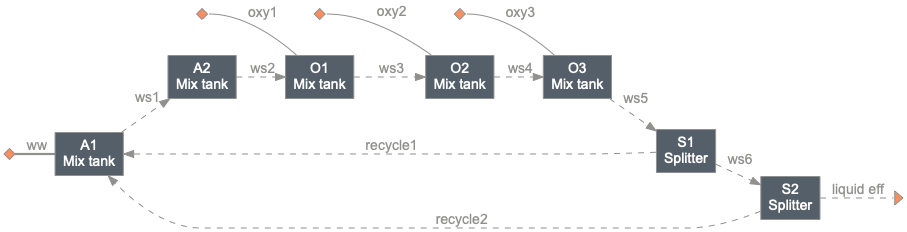

In [16]:
# Tada~! Let's take a look at the system
external_sys.diagram()

[Back to top](#top)

## 2. Retrieving useful information <a class="anchor" id="s2"></a>
Now that we have the system, we can retrieve information using the many attributes `System` has.

In [17]:
# Give it a shorthand since I'm lazy...
sys = external_sys

In [18]:
# Firstly, if you want to look at what units are within the system
sys.units

[<MixTank: A1>,
 <MixTank: A2>,
 <MixTank: O1>,
 <MixTank: O2>,
 <MixTank: O3>,
 <Splitter: S1>,
 <Splitter: S2>]

In [19]:
# Which is different from
sys.path

(<System: internal_sys>, <Splitter: S2>)

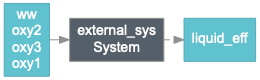

System: external_sys
Highest convergence error among components in recycle
stream S2-1 after 2 loops:
- flow rate   6.03e-01 kmol/hr (48%)
- temperature 0.00e+00 K (0%)
ins...
[0] ww
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): S_F        0.075
                    S_U_Inf    0.0325
                    C_B_Subst  0.04
                    X_B_Subst  0.227
                    X_U_Inf    0.0558
                    X_Ig_ISS   0.0523
                    S_NH4      0.00147
                    ...
[1] oxy1
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): S_N2  1.17
                    S_O2  0.312
[2] oxy2
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): S_N2  1.17
                    S_O2  0.312
[3] oxy3
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): S_N2  1.17
                    S_O2  0.312
outs...
[0] liquid_eff
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): S_F        0.0734
                    S_U_Inf    0.0319
     

In [20]:
# Similar to units, you need to first simulate the system
# before you check out attributes that are not set up
# upon initialization (e.g., units, recycles)
sys.simulate()
sys

In the above printout, you'll are actually looking at the following attributes:
- `sys.diagram('minimal')`
- `sys._error_info()`
- `sys.feeds`
- `sys.products`

In [21]:
# Ones related to costs
print(f'Purchase cost of the system equipment is {sys.purchase_cost:.0f} USD.')
print(f'Installed cost of the system equipment is {sys.installed_equipment_cost:.0f} USD.')

Purchase cost of the system equipment is 88771 USD.
Installed cost of the system equipment is 146473 USD.


In [22]:
# If you set the operating hour of the system,
# you can also see costs related to operation
sys.operating_hours = 365*0.8

In [23]:
# Electricity
print(f'This system uses {sys.get_electricity_consumption():.2f} kWh electricity per year.')
print(f'This system produces {sys.get_electricity_production():.2f} kWh electricity per year.')

This system uses 259.21 kWh electricity per year.
This system produces 0.00 kWh electricity per year.


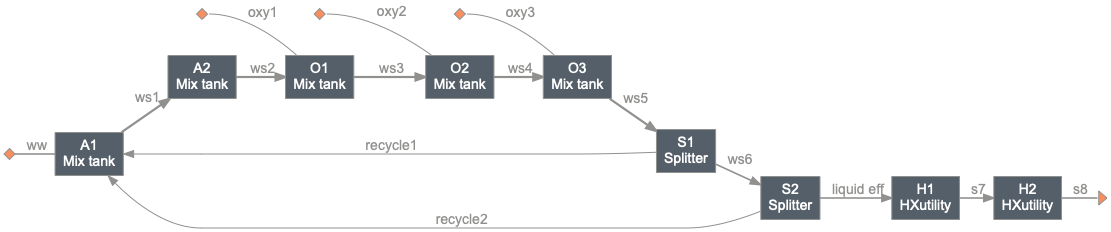

Cooling duty of the second system is 37635939.66 kJ per year.
Heating duty of the second system is 33018236.42 kJ per year.


In [24]:
# And many others related to heating and cooling utilities,
# since there is no use of heating/cooling duties in our system,
# let's just add two new units to demonstrate it
H1 = qs.sanunits.HXutility('H1', ins=sys-0, T=50+273.15)
H2 = qs.sanunits.HXutility('H2', ins=H1-0, T=20+273.15)
sys2 = bst.System('sys2', path=(sys, H1, H2))
sys2.operating_hours = sys.operating_hours
sys2.simulate()
sys2.diagram()
print(f'Cooling duty of the second system is {sys2.get_cooling_duty():.2f} kJ per year.')
print(f'Heating duty of the second system is {sys2.get_heating_duty():.2f} kJ per year.')

[Back to top](#top)